<a href="https://colab.research.google.com/github/pmckim1/Datathon/blob/main/Datathon_submission_McKim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATATHON 2021
###Polly McKim 
###This workbook was created for GWU's 2021 Datathon competition. The goal is to predict whether a vehicular crash will be fatal or not based on other features present. 


---
# Abstract 
Fatalities due to vehicle collusions are a rare event in DC. When they do occur a larger proportion involved speeding and impairment than non-fatal collusions. Pedestrians and Bike Riders are also at an increased risk.  A treebased model works well for creating an explainable predictive model for a government entity. The findings of this data exploration are in line with reports generated by the Dept of Transportation addressing this topic.  Encouraging safer behavior, vehicles, and roadways would all work together to reduce the amount of fatalities occuring. Recall was used as the measure of success it is important to correctly predict positive cases even if more false positives occur. The histgradientboost model achieved the best recall score. However, the random forest offered better explainability, which may be importannt in this context. Nevertheless, the model likely would not be able to be deployed in the real world because the features recorded would not be known before an incident. Significant data leakage would need to occur for this model to ever be deployed.  However, other features such as weather and road condition could be collected before an incident to work towards a more accurate and realistic predictive model.  



In [913]:
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras

In [914]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [915]:
import numpy as np
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

from google.colab import drive
import json 
import sys
import pandas as pd
import datetime as dt
pd.set_option('display.max_columns', None)
import plotly.express as px
pd.set_option('display.max_columns', None)



In [916]:
# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr =  '/content/drive/My Drive/Datathon/'

# Get the absolute path of the shallow utilities folder
abspath_util_shallow = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/fall_2020/code/utilities/p2_shallow_learning/'

# Get the absolute path of the shallow models folder
abspath_model_shallow = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/fall_2020/code/models/p2_shallow_learning/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [917]:
# Change working directory to the absolute path of the shallow utilities folder
%cd $abspath_util_shallow

# Import the shallow utitilities
%run pmlm_utilities_shallow.ipynb

/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/fall_2020/code/utilities/p2_shallow_learning


In [918]:
# import additional libraries 
import os
import sys
import numpy as np
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
from itertools import combinations
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import StackingClassifier
import seaborn as sns



In [919]:
# run on increased RAM 
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [920]:
#Load data 
df_raw = pd.read_csv(abspath_curr +'Crash_Details_Table.csv', header=0)

In [921]:
# inspect data 
print(df_raw.columns)
print(len(df_raw))
print(df_raw.head())

# add one count row for easier aggregation 
df_raw['accidents'] = 1

Index(['OBJECTID', 'CRIMEID', 'CCN', 'PERSONID', 'PERSONTYPE', 'AGE', 'FATAL',
       'MAJORINJURY', 'MINORINJURY', 'VEHICLEID', 'INVEHICLETYPE',
       'TICKETISSUED', 'LICENSEPLATESTATE', 'IMPAIRED', 'SPEEDING'],
      dtype='object')
596381
    OBJECTID   CRIMEID       CCN  PERSONID PERSONTYPE   AGE FATAL MAJORINJURY  \
0  438194351  26872544  16034312  84628234  Passenger  31.0     N           N   
1  438194352  26872544  16034312  84833902  Passenger  31.0     N           N   
2  438194353  26872544  16034312  84938064     Driver   NaN     N           N   
3  438194354  26872544  16034312  84790164     Driver  31.0     N           N   
4  438194355  26872544  16034312  84953497  Passenger  47.0     N           N   

  MINORINJURY VEHICLEID             INVEHICLETYPE TICKETISSUED  \
0           N   2275009  Passenger Car/automobile            N   
1           N   2275009  Passenger Car/automobile            N   
2           N   2275007  Passenger Car/automobile            N   
3    

# Data Clean Up
I will also perform some light EDA in this section to inform what needs to be cleaned. 


In [922]:
# see what if any data is missing 
#%%
def missing_values_table(df):
    # Utility function, identify missing data and show percentages.
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\nThere are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    return mis_val_table_ren_columns


#%%
# see if any values are missing 
missing_values_table(df_raw)


Your selected dataframe has 16 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
AGE,169637,28.4


In [923]:
# we will fill missing ages with the mean for now 
#df_raw['AGE'] = df_raw['AGE'].fillna((df_raw['AGE'].mean()))
df_raw=df_raw.dropna(subset=['AGE'])


## Missing Data
This missing data funxtion shows that age is missing data. Since this data came from a local government source, I would guess that additional data is missing somewhere in the set. Therefore, I will be on the lookout to see how that data is coded. For now we will fill the missing ages with the mean of the column.  

In [924]:
# continue the data cleaning 
# print value counts for all columns to determine if additional cleaning is needed
for column in df_raw.columns:
     print("\n" + column)
     print(df_raw[column].value_counts())


OBJECTID
438306815    1
438200165    1
438317228    1
438319277    1
438313134    1
            ..
438764981    1
438769079    1
438789561    1
438783420    1
438306817    1
Name: OBJECTID, Length: 426744, dtype: int64

CRIMEID
27250936    58
28296982    48
27338818    46
27865960    45
27122910    42
            ..
26624638     1
26636920     1
28186006     1
26610295     1
24709033     1
Name: CRIMEID, Length: 224351, dtype: int64

CCN
17044398    58
20014518    48
17100473    46
18197669    44
16192573    42
            ..
15073344     1
11044216     1
11091077     1
14106865     1
11010046     1
Name: CCN, Length: 224410, dtype: int64

PERSONID
89764243    2
90219441    2
90135860    2
89514186    2
89550113    2
           ..
89705038    1
90704470    1
85490264    1
89776747    1
87037955    1
Name: PERSONID, Length: 426734, dtype: int64

PERSONTYPE
Driver        364655
Passenger      52274
Pedestrian      5962
Bicyclist       3853
Name: PERSONTYPE, dtype: int64

AGE
 0.0      1

## Cleaning error values 
There is a lot of weird data as seen above so I will clean likely errors and get rid of some very small values that will not materially change the dataset.

In [925]:
# perform a lot of clean up based on above value counts 

# remove states that barely appear 
state_remove=["Am", "Pu"]     
df_raw = df_raw[~df_raw['LICENSEPLATESTATE'].isin(state_remove)]

# remove vehicleids that show up more than 50 times as it is unlikely same car is getting in many accidents)

vehicle_remove=["1012204", "884780", "2761084", "908411", "823706", "842950", "759379",
"824345", "960709", "921609"]      
df_raw = df_raw[~df_raw.VEHICLEID.isin(vehicle_remove)]

# clean up Vehicle type column of entries that dont make sense
remove = ['Drugs/ Narcotics','Firearms', "Watercraft/boat", "Aircraft", "Snow Mobile"]
df_raw = df_raw[~df_raw.INVEHICLETYPE.isin(remove)]
print(df_raw.columns)


Index(['OBJECTID', 'CRIMEID', 'CCN', 'PERSONID', 'PERSONTYPE', 'AGE', 'FATAL',
       'MAJORINJURY', 'MINORINJURY', 'VEHICLEID', 'INVEHICLETYPE',
       'TICKETISSUED', 'LICENSEPLATESTATE', 'IMPAIRED', 'SPEEDING',
       'accidents'],
      dtype='object')


In [926]:
print(df_raw.VEHICLEID.value_counts())

None       9427
5131329      47
3035149      46
3212094      45
4266229      44
           ... 
2371143       1
5755318       1
927756        1
1014433       1
807717        1
Name: VEHICLEID, Length: 354661, dtype: int64


In [927]:
# drop the columnns that dont tell us anything/ serve as ids 
df_raw=df_raw.drop(["OBJECTID","CRIMEID", "PERSONID", "CCN", "VEHICLEID"], axis=1)

In [928]:
# these should possibly be combined into smaller categories 
df_raw.INVEHICLETYPE.value_counts()

Passenger Car/automobile                      299394
Other Vehicle                                  28294
Suv (sport Utility Vehicle)                    23375
Bus                                            14415
Passenger Van                                  13468
None                                            9473
Pickup Truck                                    8780
Large/heavy Truck                               8372
Cargo Van                                       3876
Other Small/light Truck                         2846
Motor Cycle                                     2194
Moped/scooter                                   1060
Construction/industrial Equipment                658
Trailer                                          335
Motorhome/camper/rv (recreational Vehicle)       216
Farm Equipment                                   131
Atv (all Terrain Vehicle)                        104
Name: INVEHICLETYPE, dtype: int64

In [929]:
# age column needs more cleaning 
df_raw=df_raw[(df_raw['AGE'] >= 0) & (df_raw['AGE'] < 100)]
print(df_raw.AGE.value_counts())

0.0     13129
26.0    11805
27.0    11792
25.0    11738
28.0    11719
        ...  
95.0       27
97.0       19
96.0       19
98.0       17
99.0       15
Name: AGE, Length: 100, dtype: int64


In [930]:
pd.pivot_table(part_age,index="AGE",columns="PERSONTYPE", aggfunc=len)

#some of these values arent realistic so more cleaning is needed


PERSONTYPE,Bicyclist,Driver,Passenger,Pedestrian
AGE,,,,
0.0,46.0,11247.0,1765.0,71.0
1.0,1.0,50.0,742.0,17.0
2.0,NaN,44.0,713.0,26.0
3.0,NaN,34.0,728.0,33.0
4.0,3.0,30.0,738.0,28.0
...,...,...,...,...
95.0,NaN,20.0,6.0,1.0
96.0,NaN,15.0,4.0,NaN
97.0,NaN,12.0,6.0,1.0


## Age Clean Up 
It appears the some of the very high age numbers and very low age numbers are listed as drivers when this is not likely. maybe if age is unknown it is entered as zero? 

I will leave the zero aged drivers for now but I will remove the very old drivers and drivers less than 15




In [931]:
df_raw = df_raw.loc[((df_raw['AGE'] < 94) & (df_raw['PERSONTYPE'] == "Driver")) | (df_raw['PERSONTYPE'] != "Driver")] 
df_raw = df_raw.loc[((df_raw['AGE'] > 15) & (df_raw['PERSONTYPE'] == "Driver")) | (df_raw['PERSONTYPE'] != "Driver")] 



In [932]:
# binning for vehicle type to reduce amount of options 
def vehicle_cat (row):
   if row['INVEHICLETYPE'] == "Motorhome/camper/rv (recreational Vehicle)" :
      return "RV/Trailer"
   if row['INVEHICLETYPE']== "Trailer" :
      return "RV/Trailer"
   if row['INVEHICLETYPE'] == "None" :
      return "Other Vehicle"
   if row['INVEHICLETYPE'] == "Other Vehicle" :
      return "Other Vehicle"
   if row['INVEHICLETYPE'] == "Passenger Van" :
      return "Van"
   if row['INVEHICLETYPE'] == "Cargo Van" :
      return "Van"
   if row['INVEHICLETYPE'] == "Passenger Car/automobile" :
      return "Passenger Car/automobile"
   if row['INVEHICLETYPE'] == "Pickup Truck" :
      return "Truck"
   if row['INVEHICLETYPE'] == "Large/heavy Truck" :
      return "Truck"
   if row['INVEHICLETYPE'] == "Other Small/light Truck" :
      return "Truck"
   if row['INVEHICLETYPE'] == "Motor Cycle" :
      return "Motorcycle/Scooter"
   if row['INVEHICLETYPE'] == "Moped/scooter" :
      return "Motorcycle/Scooter"
   if row['INVEHICLETYPE'] == "Bus" :
      return "Bus"
   if row['INVEHICLETYPE'] == "Construction/industrial Equipment" :
      return "Construction/industrial Equipment"
   if row['INVEHICLETYPE'] == "Suv (sport Utility Vehicle)" :
      return "Suv (sport Utility Vehicle)"
   if row['INVEHICLETYPE'] == "Farm Equipment" :
      return "Farm Equipment/ATV"
   if row['INVEHICLETYPE'] == "Atv (all Terrain Vehicle)" :
      return "Farm Equipment/ATV"
   return "Other"

df_raw['INVEHICLETYPE_CAT'] = df_raw.apply (lambda row: vehicle_cat(row), axis=1)

In [ ]:
# continue the data cleaning 
# print value counts for all columns to determine if additional cleaning is needed
for column in df_raw.columns:
     print("\n" + column)
     print(df_raw[column].value_counts())

# EDA
This section will include exploration of the data 

## Total Amount of Fatalities 
We see that the amount of fatalities is very low comapred to nonfatal (See bar chart & cumber chart below). The fatalities are so small they do not even register on the bar chart. Since the dataset is very imbalanced we need to be mindful of this going forward. 

In [ ]:
combined1 = df_raw.groupby(["FATAL"]).count().reset_index()

fig = px.bar(combined1,
             y="accidents",
             x="FATAL",
             color='FATAL', 
             title="Fatal Versus Non-Fatal Collisions")
fig.show()
print(df_raw.FATAL.value_counts())

## Speed and Fatal versus NonFatal 

The pie chart shows that speeding is much more common proportionally in fatal accidents than in nonfatal accidents. We will keep this in mind for the future.

In [908]:



# get percent of SPEED accidents compared to overall accidents 
combined_01 = df_raw.groupby(["FATAL", "SPEEDING"]).sum().reset_index()

# percent SPEED column -- create calculated column 
combined_01["pct_speed"] = ""
for fatal in combined_01["FATAL"].unique():
  fatal_df = combined_01[combined_01["FATAL"] == fatal]
  speed_accidents = fatal_df[fatal_df["SPEEDING"]=="SPEED"]["accidents"].sum()
  no_speed_accidents = fatal_df[fatal_df["SPEEDING"]=="No_Speed"]["accidents"].sum()
  pct = speed_accidents / (speed_accidents + no_speed_accidents)
  print("SPEED", speed_accidents, "No_SPEED", no_speed_accidents, "pct", pct)
  combined_01["pct_speed"].loc[(combined_01['FATAL'] == fatal) & (combined_01["SPEEDING"]=="SPEED")] = speed_accidents / (speed_accidents + no_speed_accidents)
  combined_01["pct_speed"].loc[(combined_01['FATAL'] == fatal) & (combined_01["SPEEDING"]=="No_Speed")] = no_speed_accidents / (speed_accidents + no_speed_accidents)
print(combined_01.accidents)

SPEED 0 No_SPEED 0 pct nan
SPEED 0 No_SPEED 0 pct nan
0    401036
1      3090
2       252
3        42
Name: accidents, dtype: int64


In [909]:
fig = px.pie(combined_01[combined_01["FATAL"]=="Y"], values='accidents', names='SPEEDING', title="Speeding in Fatal Accidents")
fig.show()

fig = px.pie(combined_01[combined_01["FATAL"]=="N"], values='accidents', names='SPEEDING', title="Speeding in Non-Fatal Accidents")
fig.show()

## Impairment and Fatal versus NonFatal
Like speed, the pie chart shows that impairment is much more common proportionally in fatal accidents than in nonfatal accidents. The difference in proportions are not as notable as the difference for speed. Nevertheless, we will keep this in mind for the future.

In [910]:
# get percent of impaired accidents compared to overall accidents 
combined_01 = df_raw.groupby(["FATAL", "IMPAIRED"]).sum().reset_index()

# percent impaired column -- create calculated column 
combined_01["pct_impaired"] = ""
for fatal in combined_01["FATAL"].unique():
  fatal_df = combined_01[combined_01["FATAL"] == fatal]
  impaired_accidents = fatal_df[fatal_df["IMPAIRED"]=="impaired"]["accidents"].sum()
  no_impaired_accidents = fatal_df[fatal_df["IMPAIRED"]=="No_impaired"]["accidents"].sum()
  pct = impaired_accidents / (impaired_accidents + no_impaired_accidents)
  print("impaired", impaired_accidents, "No_impaired", no_impaired_accidents, "pct", pct)
  combined_01["pct_impaired"].loc[(combined_01['FATAL'] == fatal) & (combined_01["IMPAIRED"]=="impaired")] = impaired_accidents / (impaired_accidents + no_impaired_accidents)
  combined_01["pct_impaired"].loc[(combined_01['FATAL'] == fatal) & (combined_01["IMPAIRED"]=="No_impaired")] = no_impaired_accidents / (impaired_accidents + no_impaired_accidents)



impaired 0 No_impaired 0 pct nan
impaired 0 No_impaired 0 pct nan


In [911]:
fig = px.pie(combined_01[combined_01["FATAL"]=="Y"], values='accidents', names='IMPAIRED', title="Impairment in Fatal Accidents")
fig.show()

fig = px.pie(combined_01[combined_01["FATAL"]=="N"], values='accidents', names='IMPAIRED', title="Impairment in Non-Fatal Accidents")
fig.show()

## Vehicle type for Fatal and Non-Fatal 

This feature is difficult to parse because it has so many different categories and a lot of the data is listed as not recorded. However, we can clearly see that motorcycles & scooters are involved with more fatalities. This makes sense as there is not as much crash protection in this type of vehicle compared to a car. 


In [935]:
# vehicle types in accidents
# get percent of INVEHICLETYPE_CAT accidents compared to overall accidents 

combined_04 = df_raw.groupby(["FATAL", "INVEHICLETYPE_CAT"]).sum().reset_index()

# percent INVEHICLETYPE_CAT column -- create calculated column 
combined_04["pct_INVEHICLETYPE_CAT"] = ""
for fatal in combined_04["FATAL"].unique():
  print(fatal)
  fatal_df = combined_04[combined_04["FATAL"] == fatal]
  INVEHICLETYPE_CAT_accidents = fatal_df[fatal_df["INVEHICLETYPE_CAT"]=="INVEHICLETYPE_CAT"]["accidents"].sum()
  no_INVEHICLETYPE_CAT_accidents = fatal_df[fatal_df["INVEHICLETYPE_CAT"]=="No_INVEHICLETYPE_CAT"]["accidents"].sum()
  pct = INVEHICLETYPE_CAT_accidents / (INVEHICLETYPE_CAT_accidents + no_INVEHICLETYPE_CAT_accidents)
  print("INVEHICLETYPE_CAT", INVEHICLETYPE_CAT_accidents, "No_INVEHICLETYPE_CAT", no_INVEHICLETYPE_CAT_accidents, "pct", pct)
  combined_04["pct_INVEHICLETYPE_CAT"].loc[(combined_04['FATAL'] == fatal) & (combined_04["INVEHICLETYPE_CAT"]=="INVEHICLETYPE_CAT")] = INVEHICLETYPE_CAT_accidents / (INVEHICLETYPE_CAT_accidents + no_INVEHICLETYPE_CAT_accidents)
  combined_04["pct_INVEHICLETYPE_CAT"].loc[(combined_04['FATAL'] == fatal) & (combined_04["INVEHICLETYPE_CAT"]=="No_INVEHICLETYPE_CAT")] = no_INVEHICLETYPE_CAT_accidents / (INVEHICLETYPE_CAT_accidents + no_INVEHICLETYPE_CAT_accidents)
#print(combined_04.accidents)
print(combined_04[["INVEHICLETYPE_CAT", "accidents"]])

N
INVEHICLETYPE_CAT 0 No_INVEHICLETYPE_CAT 0 pct nan
Y
INVEHICLETYPE_CAT 0 No_INVEHICLETYPE_CAT 0 pct nan
                    INVEHICLETYPE_CAT  accidents
0                                 Bus      14285
1   Construction/industrial Equipment        642
2                  Farm Equipment/ATV        212
3                  Motorcycle/Scooter       3075
4                       Other Vehicle      36950
5            Passenger Car/automobile     289721
6                          RV/Trailer        534
7         Suv (sport Utility Vehicle)      22608
8                               Truck      19273
9                                 Van      16826
10                                Bus          1
11                 Farm Equipment/ATV          1
12                 Motorcycle/Scooter         36
13                      Other Vehicle         79
14           Passenger Car/automobile        149
15        Suv (sport Utility Vehicle)         11
16                              Truck          6
17          

In [936]:
fig = px.pie(combined_04[combined_04["FATAL"]=="Y"], values='accidents', names='INVEHICLETYPE_CAT', title="Vehicle Type in Fatal Accidents")
fig.show()

fig = px.pie(combined_04[combined_04["FATAL"]=="N"], values='accidents', names='INVEHICLETYPE_CAT', title="Vehicle Type in Non-Fatal Accidents")
fig.show()

## Person Type in Fatal versus NonFatal
The pie chart shows that passengers make up a much greater portion of fatal incidents in the dataset. This could be because their involvement is not recorded unless they succumb to a crash. Bicyclists and pedestrians also make up a higher percentage in the fatal group. This is likely because if such a person is involved in a collison they are more likely to pass away since a car likely offers more protection against severe injury leading to death.  

In [933]:
# person types in accidents
# get percent of PERSONTYPE accidents compared to overall accidents 
combined_05 = df_raw.groupby(["FATAL", "PERSONTYPE"]).sum().reset_index()

# percent PERSONTYPE column -- create calculated column 
combined_05["pct_PERSONTYPE"] = ""
for fatal in combined_05["FATAL"].unique():
  fatal_df = combined_05[combined_05["FATAL"] == fatal]
  PERSONTYPE_accidents = fatal_df[fatal_df["PERSONTYPE"]=="PERSONTYPE"]["accidents"].sum()
  no_PERSONTYPE_accidents = fatal_df[fatal_df["PERSONTYPE"]=="No_PERSONTYPE"]["accidents"].sum()
  pct = PERSONTYPE_accidents / (PERSONTYPE_accidents + no_PERSONTYPE_accidents)
  print("PERSONTYPE", PERSONTYPE_accidents, "No_PERSONTYPE", no_PERSONTYPE_accidents, "pct", pct)
  combined_05["pct_PERSONTYPE"].loc[(combined_05['FATAL'] == fatal) & (combined_05["PERSONTYPE"]=="PERSONTYPE")] = PERSONTYPE_accidents / (PERSONTYPE_accidents + no_PERSONTYPE_accidents)
  combined_05["pct_PERSONTYPE"].loc[(combined_05['FATAL'] == fatal) & (combined_05["PERSONTYPE"]=="No_PERSONTYPE")] = no_PERSONTYPE_accidents / (PERSONTYPE_accidents + no_PERSONTYPE_accidents)
#print(combined_05.accidents)


PERSONTYPE 0 No_PERSONTYPE 0 pct nan
PERSONTYPE 0 No_PERSONTYPE 0 pct nan


In [934]:
fig = px.pie(combined_05[combined_05["FATAL"]=="Y"], values='accidents', names='PERSONTYPE', title="Person Types in Fatal Accidents")
fig.show()

fig = px.pie(combined_05[combined_05["FATAL"]=="N"], values='accidents', names='PERSONTYPE', title="Person Types in Non-Fatal Accidents")
fig.show()

# Preprocessing of Data 

In [ ]:
# value_counts for all columns 
df_raw["FATAL"]= df_raw["FATAL"].replace("N", 0)
df_raw["FATAL"]= df_raw["FATAL"].replace("Y", 1)

# dropped duplicate type column 
df_raw=df_raw.drop(["INVEHICLETYPE"], axis=1)

In [ ]:
# get name of target
target="FATAL"

In [ ]:
# Make a copy of df_raw_test
df = df_raw.copy(deep=True)
df = df.dropna()


In [ ]:
# Divide the  data into training (80%) and test (20%)

df_train, df_test = train_test_split(df, 
                                     train_size=0.8, 
                                     random_state=random_seed, 
                                     stratify=df[target])

In [ ]:
# Divide the training data into training (60%) and validation (40%)

df_val, df_test = train_test_split(df_test, 
                                   train_size=0.8, 
                                   random_state=random_seed, 
                                   stratify=df_test[target])

In [ ]:
# handle uncommon features
# Call common_var_checker
# See the implementation in pmlm_utilities.ipynb
df_common_var = common_var_checker(df_train, df_val, df_test, target)

# Print df_common_var
df_common_var

In [ ]:
# Get the features in the training data but not in the validation or test data
uncommon_feature_train_not_val_test = np.setdiff1d(df_train.columns, df_common_var['common var'])

# Print the uncommon features
pd.DataFrame(uncommon_feature_train_not_val_test, columns=['uncommon feature'])

In [ ]:
# Get the features in the training data but not in the validation or test data
uncommon_feature_train_not_val_test = np.setdiff1d(df_train.columns, df_common_var['common var'])

# Print the uncommon features
pd.DataFrame(uncommon_feature_train_not_val_test, columns=['uncommon feature'])

In [ ]:
# Get the features in the test data but not in the training or validation data
uncommon_feature_test_not_train_val = np.setdiff1d(df_test.columns, df_common_var['common var'])

# Print the uncommon features
pd.DataFrame(uncommon_feature_test_not_train_val, columns=['uncommon feature'])

# no uncommon features so none need to be removed 

In [ ]:
# handling identifiers

# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

In [ ]:
# Call id_checker on df
# See the implementation in pmlm_utilities.ipynb
df_id = id_checker(df)

# Print the first 5 rows of df_id
df_id.head()

In [ ]:
# removing identifiers 
# Remove identifiers from df_train
df_train.drop(columns=np.intersect1d(df_id.columns, df_train.columns), inplace=True)

# Remove identifiers from df_val
df_val.drop(columns=np.intersect1d(df_id.columns, df_val.columns), inplace=True)

# Remove identifiers from df_test
df_test.drop(columns=np.intersect1d(df_id.columns, df_test.columns), inplace=True)

In [ ]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

In [ ]:
# identifying missing values 

# Call nan_checker on df
# See the implementation in pmlm_utilities.ipynb
df_nan = nan_checker(df)

# Print df_nan
df_nan

In [ ]:
# Print the unique data type of variables with NaN
pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype'])

In [ ]:
# Get the variables with missing values, their proportion of missing values and data type
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# Print df_miss
df_miss

In [ ]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

In [ ]:

from sklearn.impute import SimpleImputer
'''
# If there are missing values
if len(df_miss['var']) > 0:
    # The SimpleImputer
    si = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Impute the variables with missing values in df_train, df_val and df_test 
    df_train[df_miss['var']] = si.fit_transform(df_train[df_miss['var']])
    df_val[df_miss['var']] = si.transform(df_val[df_miss['var']])
    df_test[df_miss['var']] = si.transform(df_test[df_miss['var']])
  '''

In [ ]:
# encode the data 
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

# Print the unique data type of variables in df
pd.DataFrame(df.dtypes.unique(), columns=['dtype'])

In [ ]:
# for columns with lots of categories, use label encoding rather than dummies to save space 
le = LabelEncoder()


df["LICENSEPLATESTATE"] = le.fit_transform(df["LICENSEPLATESTATE"].astype(str))


In [ ]:
# The LabelEncoder


# Encode categorical target in the combined data
df[target] = le.fit_transform(df[target])

# Print the first 5 rows of df
df.head()


In [ ]:
# identifying categorical data 
# Call cat_var_checker on df
# See the implementation in pmlm_utilities.ipynb
df_cat = cat_var_checker(df)

# Print the dataframe
df_cat

In [ ]:
# One-hot-encode the categorical features in the combined data
df = pd.get_dummies(df, columns=np.setdiff1d(df_cat['var'], [target]))

# Print the first 5 rows of df
df.head()

In [ ]:
# The LabelEncoder

le = LabelEncoder()

# Encode categorical target in the combined data
df[target] = le.fit_transform(df[target])

# Print the first 5 rows of df
df.head()


In [ ]:
print(df.columns)

In [ ]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

In [ ]:
# splitting the features and target
# Get the feature matrix
X_train = df_train[np.setdiff1d(df_train.columns, [target])].values
X_val = df_val[np.setdiff1d(df_val.columns, [target])].values
X_test = df_test[np.setdiff1d(df_test.columns, [target])].values

# Get the target vector
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values


In [ ]:
# scaling the data 

# The StandardScaler
#ss = StandardScaler()
mms = MinMaxScaler()

In [ ]:
# Standardize the training data
X_train = mms.fit_transform(X_train)

# Standardize the validation data
X_val = mms.transform(X_val)

# Standardize the test data
X_test = mms.transform(X_test)

In [ ]:
# tried ros and smote. smote wins! 
'''
ros = RandomOverSampler(random_state=random_seed)

# Transforming X_ros_train and y_ros_train back to dataframes
X_ros_train, y_ros_train = X_train, y_train

'''
from imblearn.over_sampling import SMOTE

# The SMOTE
smote = SMOTE(random_state=random_seed)

# Augment the training data
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)


# Model Building 


In [ ]:
models = {#'lr': LogisticRegression(class_weight='balanced', random_state=42),
          'dtc': DecisionTreeClassifier(class_weight='balanced', random_state=42),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=42)#, 
          #'hgbc': HistGradientBoostingClassifier(random_state=42) #,

}
# %%
# dictionary for the pipelines 
# build pipeline for each model


pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])


from sklearn.model_selection import PredefinedSplit

def get_train_val_ps(X_train, y_train, X_val, y_val):
    """
    Get the:
    feature matrix and target velctor in the combined training and validation data
    target vector in the combined training and validation data
    PredefinedSplit
    
    Parameters
    ----------
    X_train : the feature matrix in the training data
    y_train : the target vector in the training data
    X_val : the feature matrix in the validation data
    y_val : the target vector in the validation data  

    Return
    ----------
    The feature matrix in the combined training and validation data
    The target vector in the combined training and validation data
    PredefinedSplit
    """  

    # Combine the feature matrix in the training and validation data
    X_train_val = np.vstack((X_train, X_val))

    # Combine the target vector in the training and validation data
    y_train_val = np.vstack((y_train.reshape(-1, 1), y_val.reshape(-1, 1))).reshape(-1)

    # Get the indices of training and validation data
    train_val_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_val.shape[0], 0))

    # The PredefinedSplit
    ps = PredefinedSplit(train_val_idxs)

    return X_train_val, y_train_val, ps




#X_train_valid, y_train_valid, ps = get_train_val_ps(X_ros_train, y_ros_train, X_val, y_val)
X_train_valid, y_train_valid, ps = get_train_val_ps(X_smote_train, y_smote_train, X_val, y_val)
#X_train_valid, y_train_valid, ps = get_train_val_ps(X_train, y_train, X_val, y_val)



#%%
#Creating the dictionary of the parameter grids
#In the dictionary:
#the key is the acronym of the model
#the value is the parameter grid of the model

# instantiate parameter grids
param_grids = {}

#The parameter grid for logistic regression
#The hyperparameters we want to fine-tune are:

#C
#tol
# The grids for C
C_grids = [10 ** i for i in range(-2, 3)]

# The grids for tol
tol_grids = [10 ** i for i in range(-6, -1)]

# Update param_grids
param_grids['lr'] = [{'model__C': C_grids,
                      'model__tol': tol_grids}]

#The parameter grid for decision tree
#The hyperparameters we want to fine-tune are:

#min_samples_split
#min_samples_leaf
#See details of the meaning of the hyperparametes in sklearn.tree.DecisionTreeClassifier


# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['dtc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]


#The parameter grid for Adaboost
#The hyperparameters we want to fine-tune are:

#learning_rate
#See details of the meaning of the hyperparametes in sklearn.ensemble.AdaBoostClassifier

# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# Update param_grids
param_grids['abc'] = [{'model__learning_rate': learning_rate_grids}]

#%%
#The parameter grid for HistGradientBoosting
#The hyperparameters we want to fine-tune are:

#learning_rate
#min_samples_leaf
#See details of the meaning of the hyperparametes in sklearn.ensemble.HistGradientBoostingClassifier

# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]



#The parameter grid for random forest
#The hyperparameters we want to fine-tune are:

#min_samples_split
#min_samples_leaf
#See details of the meaning of the hyperparametes in sklearn.ensemble.RandomForestClassifier

#In [125]:
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]



# make directory for cv results 


#%%
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
# Make directory
# Make directory
directory = os.path.dirname(abspath_curr + '/cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)
#%%    


In [859]:
# hyperparameter tuning 
# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_micro',
                      n_jobs=-1,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf='./cv_results/' + acronym + '.csv', index=False)


# Evaluating the Models 

In [860]:
# Sorting best_score_params_estimator_gs in descending order based on 
# best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Printing best_score_params_estimator_gs
pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])   

,best_score,best_param,best_estimator
0,0.985566,"{'model__min_samples_leaf': 1, 'model__min_sam...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
1,0.985303,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."
2,0.957037,"{'model__learning_rate': 0.1, 'model__min_samp...",(HistGradientBoostingClassifier(l2_regularizat...


In [861]:
#This action is performed to find what benchmarks the model need to surpass.

y_test = pd.Series(y_test)

print("Class Distribution:", y_test.value_counts())

# Calculating and printing the percentage of ones
print("Percentage of Ones:", y_test.mean())

# Calculating and printing the percentage of zeros
print("Percentage of Zeros:", 1 - y_test.mean())

# Calculating and printing the null accuracy (for binary classification problems 
# coded as 0 or 1)
print("Null Accuracy:",max(y_test.mean(), 1 - y_test.mean()))


Class Distribution: 0    16165
1       12
dtype: int64
Percentage of Ones: 0.0007417939049267478
Percentage of Zeros: 0.9992582060950732
Null Accuracy: 0.9992582060950732


In [862]:
# ## Retrieving the precision and best scores for each model
# The list of [precision, recall, fscore, best_estimator]
precision_recall_fscore_best_estimator = []

for best_score, best_param, best_estimator in best_score_param_estimator_gs:
      # Retrieving the prediction
      y_pred = best_estimator.predict(X_test)

      # Retrieving the precision, recall, fscore, support
      precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)#, average='macro')

      # Retrieving the auc
      # auc = roc_auc_score(y_test, y_pred)

      # Updating 'precision_recall_fscore_auc_best_estimator'
      precision_recall_fscore_best_estimator.append([precision, recall, fscore, best_estimator])

# Returning precision_recall_fscore_best_estimator
#print(pd.DataFrame(precision_recall_fscore_best_estimator, columns=['Precision', 'Recall', 'F1-score', 'Model']))

cat = pd.DataFrame(precision_recall_fscore_best_estimator, columns=['Precision', 'Recall', 'F1-score', 'Model'])
  

In [863]:
pd.set_option('display.max_columns', None)
print(cat.iloc[:,:4])

                                    Precision  \
0  [0.9993094356205663, 0.004032258064516129]   
1   [0.999309262166405, 0.003968253968253968]   
2  [0.9995528585116576, 0.009578544061302681]   

                                      Recall  \
0  [0.9847200742344572, 0.08333333333333333]   
1   [0.984472626043922, 0.08333333333333333]   
2   [0.9680173213733374, 0.4166666666666667]   

                                     F1-score  \
0  [0.9919611142269583, 0.007692307692307693]   
1  [0.9918354627609848, 0.007575757575757576]   
2  [0.9835323695788811, 0.018726591760299623]   

                                               Model  
0  (DecisionTreeClassifier(ccp_alpha=0.0, class_w...  
1  ((DecisionTreeClassifier(ccp_alpha=0.0, class_...  
2  (HistGradientBoostingClassifier(l2_regularizat...  


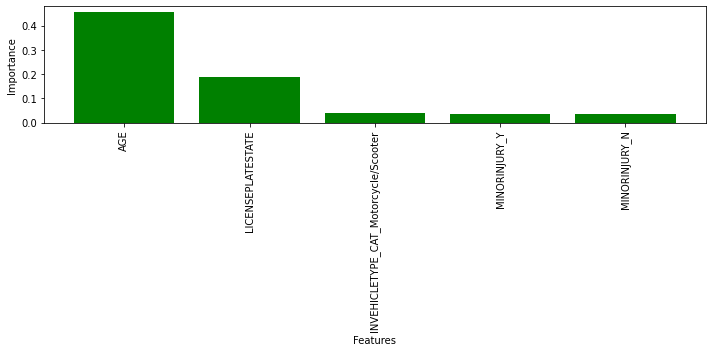

In [887]:
# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_param_estimator_gs[1]


# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((np.setdiff1d(df.columns, [target]).reshape(-1, 1), best_estimator_rfc.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the first 5 rows of df_fi_rfc
df_fi_rfc.head()

# Get the dataframe of feature and importance
# Create a figure
fig = plt.figure(figsize=(10, 5))

# Implement me
# The bar plot of the top 5 feature importance
plt.bar(df_fi_rfc['Features'][:5], df_fi_rfc['Importance'][:5], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.show()

# Overall Findings 

## Exploratory Findings
Fatalities due to collisions are thankfully exceedingly rare in DC.  However, speeding and impairment were present is a higher proportion of fatal cases versus non fatal ones.  More passengers were also recorded in fatal cases. However, I suspect this may be partially a data recording error since not all passengers are likely to be recorded if they are invovled in less serious incidents. Pedestrians and bike riders also made up a larger proportion of fatal cases. This is likely due to the fact that a car will give some protection that pedestrians and bike riders do not have.  

## Model 
Since this model is for predicting information for a government client that likely would be publishing data for the public, I wanted a more explanable type model. Fromw orking for the federal government as a data scientist currently, I know that the explainability of a model is a highly sought after feature in this type of situation.  Therefore, I focused on treebased models which have the ability to determine which features are important to overall prediction. 
I ran three models- a decision tree, a random forest, and a histgradientboost. Comparing the results of the ML models reveals high accuracy. However, in comparison to the highly imbalanced dataset, the accuracy measure is not important. NEvertheless, several of the models show a slight improvement over random guessing. In the context of this project, the ML models should focus on accurately predicting likely fatalities , so more false positives are ok. Thus, “Recall” was considered the most important factor in our evaluation. Therefore, the Histgradientboost model which acheived a recall of 41% for predicting the fatalities is the winner. Nevertheless, as I mentioned before, governements like explainable models, so the random forest, which enables feature importance measures may be a better choice despite its lower recall of 08.3%. 


## Future Exploration
Some examples of other features I would want to possibly investigate to improve the true predictive power of the model
Weather at the time of the crash 

*   Weather at the time of the crash 
*   Time of the crash Day of the week of crash 
*   Day of the week of crash 
*   Month of crash 
*   Information on roadway conditions
*   List item



## Recommendations and Literature Review 

Although the findings in this mini data analysis likely barely scratch the surface in terms of how to prevent collision deaths, my findings are consistent with the findings of the Department of Transportation which used traffic related information to work towards "Reducing the rate of roadway fatalities from 1.26 in 2008 to 1.03 per 100 million vehicle miles traveled (VMT) by December 31, 2018."  The study released by the department cited the following strategies as responsible for previous drops in deaths and continuing methods to further reduce these deaths--
1. Safer Behaviors 
2. Safer Vehicles
3. Safer Roadways & walkways

   
The first strategy above aligns with my findings on speed and impairment. If these two behaviors were worked to be irradicated from driving behaviors, the amount of fatalities would likely drop.  Texting and driving, mentioned by the Obama study is also likely a factor and should be discouraged in effort to lower fatalities.  

The second strategy of safer vehicles aligns with our findings that makes sense given that motorcycles/ scooters had more instances of fatalities. If we could make these vehicles safer, or ideally, give them a seperate protected lane to drive in then fatalities would likely drop even more.  

The third strategy for reducing fatalities layed out by the Obama administration, safer roadways & walkways, would likely also have a positive influence on lowering numbers.  As mentioned previously, pedestrians and bike riders are at increased risk.  If pedestrians had safer places to walk and bike riders coulld ride in protected bikelanes, fatalities would likely further drop.  


## Limitations 
I am not sure how useful this prediction model would be if it were employed by the DC government.  Many of the features used to make predictions would not be available before the crash has happened. This is an example of data leakage. If If I was going to create a model for actual deployment. I would like to use features such as the ones I listed above for future exploration. Additionally, there were many instances of missing or incomplete data.  These likely lessened the accuracy of the predictive model.    

## Sources
https://obamaadministration.archives.performance.gov/content/reduce-rate-roadway-fatalities-1.html 

